## Dry Beans Implementation and Operations Lab

In [2]:
# Import all the needed libraries
import pandas as pd
import numpy as np
from datetime import datetime
import io
import sagemaker.amazon.common as smac

import boto3
from sagemaker import get_execution_role
import sagemaker

import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data from Amazon S3

In [7]:
role = get_execution_role()
bucket = 'ars-mlops-projects'
subfolder = 'dry-beans'
Key = 'dry-beans/data/dry-beans.csv'
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=Key)
df = pd.read_csv(io.BytesIO(obj['Body'].read()))
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


##  Cleaning, transforming and preparing the dataset

In [8]:
# Transforming some of the values into correct data types

df['Class'] = df['Class'].replace({'DERMASON': 0, 'SIRA': 1, 'SEKER': 2, 'HOROZ': 3, 'CALI':4, 'BARBUNYA':5, 'BOMBAY':6 }) # target column



In [9]:
display(df.head())
display(df.shape)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,2
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,2
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,2
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,2
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,2


(13611, 17)

## Creating and training our model (Linear Learner)


In [5]:
np.random.seed(0)
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

 # This dataset will be used to train the model.
data_train = df[train_list]

# This dataset will be used to validate the model.
data_val = df[val_list]

# This dataset will be used to test the model.
data_test = df[test_list]

# Breaks the datasets into attribute numpy.ndarray and the same for target attribute.  
train_X = data_train.drop(columns='class').values
train_y = data_train['class'].values

val_X = data_val.drop(columns='class').values
val_y = data_val['class'].values

test_X = data_test.drop(columns='class').values
test_y = data_test['class'].values

In [6]:
train_file = 'dry_beans_train_recordIO_protobuf.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object('dry-beans/data/LinearLearner/{}'.format(train_file)).upload_fileobj(f)
training_recordIO_protobuf_location = 's3://{}/dry-beans/data/LinearLearner/{}'.format(bucket, train_file)
print('The Pipe mode recordIO protobuf training data: {}'.format(training_recordIO_protobuf_location))

The Pipe mode recordIO protobuf training data: s3://dry-dataset-1521/implementation_operations_lab/linearlearner_train/dry_beans_train_recordIO_protobuf.data


In [7]:
validation_file = 'dry_beans_validatioin_recordIO_protobuf.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object('dry-beans/data/LinearLearner/{}'.format(validation_file)).upload_fileobj(f)
validate_recordIO_protobuf_location = 's3://ars-mlops-projects/dry-beans/data/LinearLearner/{}'.format(bucket, validation_file)
print('The Pipe mode recordIO protobuf validation data: {}'.format(validate_recordIO_protobuf_location))

The Pipe mode recordIO protobuf validation data: s3://dry-dataset-1521/implementation_operations_lab/linearlearner_validation/dry_beans_validatioin_recordIO_protobuf.data


In [8]:
from sagemaker import image_uris
container = image_uris.retrieve('linear-learner', boto3.Session().region_name, '1') 

In [9]:
# Create a training job name
job_name = 'dry-beans-linear-learner-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

# Here is where the model-artifact will be stored
output_location = 's3://{}/implementation_operations_lab/linearlearner_output'.format(bucket)

Here is the job name dry-beans-linear-learner-job-20211028065651


In [10]:
print('The feature_dim hyperparameter needs to be set to {}.'.format(data_train.shape[1] - 1))
f_dim = data_train.shape[1] - 1

The feature_dim hyperparameter needs to be set to 16.


In [13]:
sess = sagemaker.Session()

# Setup the LinearLeaner algorithm from the ECR container
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count=1, 
                                       instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess,
                                       input_mode='Pipe')
# Setup the hyperparameters
linear.set_hyperparameters(feature_dim=f_dim,
                           predictor_type='multiclass_classifier',
                           num_classes=7,
                        early_stopping_patience=3,
                        early_stopping_tolerance=0.001,
                        epochs=15,
                        l1=0.0003891683594472962,
                        learning_rate=0.21329477268698604,
                        loss='auto',
                        mini_batch_size=1032,
                        normalize_data='true',
                        normalize_label='auto',
                        num_models='auto',
                        optimizer='auto',
                        unbias_data='auto',
                        unbias_label='auto',
                        use_bias='true',
                        wd=0.00012190629716256174
                          )

# Launch a training job. This method calls the CreateTrainingJob API call
data_channels = {
    'train': training_recordIO_protobuf_location,
    'validation': validate_recordIO_protobuf_location
}
linear.fit(data_channels, job_name=job_name)

2021-10-28 06:58:08 Starting - Starting the training job...
2021-10-28 06:58:35 Starting - Launching requested ML instancesProfilerReport-1635404288: InProgress
...
2021-10-28 06:59:04 Starting - Preparing the instances for training............
2021-10-28 07:01:08 Downloading - Downloading input data
2021-10-28 07:01:08 Training - Downloading the training image...Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/28/2021 07:01:30 INFO 140125877618496] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': '

In [14]:
print('Here is the location of the trained Linear Learner model: {}/{}/output/model.tar.gz'.format(output_location, job_name))

Here is the location of the trained Linear Learner model: s3://dry-dataset-1521/implementation_operations_lab/linearlearner_output/dry-beans-linear-learner-job-20211028065651/output/model.tar.gz


## Deploying the model into SageMaker hosting


In [15]:
multiclass_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

------!

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None, 
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            plt.cm.Greens
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [17]:
# from sagemaker.predictor import json_deserializer, csv_serializer

multiclass_predictor.serializer = sagemaker.serializers.CSVSerializer()
multiclass_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

predictions = []
results = multiclass_predictor.predict(test_X)
predictions += [r['predicted_label'] for r in results['predictions']]
predictions = np.array(predictions)

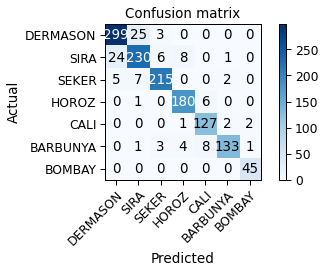

In [18]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

y_test = test_y
y_pred = predictions

class_names = np.array(['DERMASON', 'SIRA', 'SEKER', 'HOROZ', 'CALI', 'BARBUNYA', 'BOMBAY'])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [19]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

y_test = data_test['class']
y_pred = predictions
scores = precision_recall_fscore_support(y_test, y_pred, average='macro', labels=np.unique(y_pred))
acc = accuracy_score(y_test, y_pred)
print('Accuracy is: {}'.format(acc))
print('Precision is: {}'.format(scores[0]))
print('Recall is: {}'.format(scores[1]))
print('F1 score is: {}'.format(scores[2]))

Accuracy is: 0.9178491411501121
Precision is: 0.9235076962556069
Recall is: 0.9313730040820337
F1 score is: 0.9268747647217573
